In [4]:
import gensim
import subprocess
import re
import numpy as np
import time
import nltk
import os
import json
import collections
import time
import matplotlib.pyplot as plt
import itertools
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
from IPython.display import Image
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/kirov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/kirov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Problema: Determinar la veracidad de tweets, utilizando clasificación
- Implementar un clasificador de post de tweets para validar su veracidad.
- Para esto se utilizará redes neuronales y el árbol de  propagación de los tweets.


In [5]:
#Image("/home/eprovidel/Text_Mining/Proyecto/modelos.png")

In [6]:
import keras
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
keras.backend.set_session(sess)

# Parte 1: Procesamiento de datos y funcionalidades

## Parte 1.1: Cargar tweets para generar datos de entrenamiento

In [7]:
words_not_in_model = list()
def computeDocumentAWE(docText, _model, _model_vocab, _emb_size):
    """
    Calcula el AWE del texto recibido en el parámetro docText.
    La variable docSum almacena la suma de los embeddings de cada
    palabra w en docText. Luego esta suma se divide por el total
    de n palabras consideradas.
    
    Se considero una palabra para el cálculo sólo si esta pertenece
    al vocabulario del modelo. Si no, no es considerada en la suma 
    ni tampoco en el calculo de n.
    """    
    docSum = np.zeros(_emb_size)
    n = 0
    
    ####
    ## AWE = 1/n * Sum w_embedding, para cada w en docText
    ####
    
    normalizedDocText = normalizarTexto(docText)
    
    for w in normalizedDocText:
        ## Se descartan palabras que no están en el modelo de embeddings (vocabulario)
        if w in _model_vocab:
            n = n + 1
            w_embedding = _model[w]
            docSum = docSum + w_embedding
        else:
            words_not_in_model.append(w)

    return docSum / n if n > 0 else docSum    

In [8]:
def normalizarTexto(docText):
    # En gensim.utils, pasa a minúsculas, descarta palabras muy grandes o muy pequeñas.
    return simple_preprocess(docText)

In [9]:
def parseTwitterTree(tree_file):
    tree_data = list()
    for line in tree_file:
        _, second_part = line.split('->')
        second_part = second_part.rstrip()
        second_part = second_part.replace("'", "\"")
        tree_data.append(json.loads(second_part))     
    return tree_data

In [10]:
def moses():
    p = subprocess.Popen("/home/kirov/dataset/script.sh", stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
    stderr = p.communicate()
    p.wait()   

In [11]:
### Obtener diccionario con todos los posts
all_posts = {}
all_text = {}
for file in os.listdir('/home/kirov/dataset/post'):
    if file.endswith(".json"):        
        try:        
            with open(os.path.join('/home/kirov/dataset/post', file), 'r') as f:
                tweet_id  = os.path.splitext(file)[0]
                tweet_dic = json.load(f)
                all_posts[tweet_id] = tweet_dic
                all_text[tweet_id] = tweet_dic["text"] # guarda todos los textos en un diccionario con tweet_id como key

        except:
            pass
        

keys_t = all_text.keys()

### Pasa el diciconario a txt

"""
with open('/home/kirov/dataset/diccionarioID.txt', 'wb') as file:
    for k in keys_t:
        #elimina urls(opcional)
        all_text[k] = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", all_text[k])
        #elimina hashtags
        #all_text[k] = ' '.join(re.sub("(@[A-Za-z0–9]+)|([0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",all_text[k]).split())
        all_text[k] = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",all_text[k]).split())
        #elimina menciones
        
        #elimina \n molestos
        all_text[k] = all_text[k].replace('\n', '')
        #elimina palabras compuestas con guion (wake-up)
        all_text[k] = all_text[k].replace('-',' ')
        #pasa el id con el texto
        #file.write((k + ":" + all_text[k]  + "\n").encode('utf8') )
        #pasa solo el texto
        file.write((k + " " + all_text[k]  + "\n").encode('utf8') )
    else:
        print("Diccionario de textos creado")
"""


### Llamar a funcion Moses

"""
moses()
"""



### Pasar txt a diccionario

with open('/home/kirov/dataset/textTrans.txt', 'r') as file:
        count = -1
        b = [str(item) for item in keys_t]
        for file_line in file:
            count = count +1
            id_l = b[count]
            file_line = file_line.rstrip()
            all_posts[id_l]["text"] = file_line
        else:
            print("Diccionario actualizado")



### Obtener ids de tweets etiquetados
labels = {}
with open('/home/kirov/dataset/label.txt') as label_f:
    for label_line in label_f:
        
        label, tweet_id = label_line.split(':')
        tweet_id = tweet_id.rstrip()
        labels[tweet_id] = label

print("Tweets etiquetados      : ", len(labels))        

seqs_lens = []
labeled_posts = {}
number_of_tweets = 0
number_of_retweets = 0
number_of_invalid_tweets = 0
no_in_data = 0
for tweet_id in labels.keys():
    try:
        if tweet_id in all_posts:
            tree_path = os.path.join('/home/kirov/dataset/tree', tweet_id + '.txt')
            with open(tree_path) as tree_file:
                tree_data = parseTwitterTree(tree_file)
                ### Remover retweets                
                first = tree_data[0]
                without_rt = list(filter(lambda t: t[1] != tweet_id, tree_data))
                number_of_retweets = number_of_retweets + (len(tree_data) - len(without_rt))
                only_valid = list(filter(lambda t: t[1] in all_posts, without_rt))
                number_of_invalid_tweets = number_of_invalid_tweets + (len(without_rt) - len(only_valid))
                seqs_lens.append(len(only_valid))
                labeled_posts[tweet_id] = (labels[tweet_id], [first] + only_valid)
                number_of_tweets = number_of_tweets + 1 
        else:
             no_in_data = no_in_data + 1 
        
    except Exception as e:
        print(e)             
        
        
print("no_in_data              : ", no_in_data) ## están etiquetados, pero no en los post
print("number_of_tweets        : ", number_of_tweets)        
print("all_posts               : ", len(all_posts))
print("number_of_retweets      : ", number_of_retweets) ## En árbol de propagación
print("number_of_invalid_tweets: ", number_of_invalid_tweets) ## En árbol de propagación


Diccionario actualizado
Tweets etiquetados      :  818
no_in_data              :  65
number_of_tweets        :  753
all_posts               :  21741
number_of_retweets      :  297301
number_of_invalid_tweets:  6432


**Importante:** Importan sólo los datos etiquetados que se conocen y que no son retweets de cada árbol de progación.

## Parte 1.2: Aplicar AWE a cada tweet del arbol

In [12]:
## Cada palabra tiene un embedding que viene del modelo
## Se calcula AWE para cada post del árbol de propagación (lista de propagación que el primer elemento es el tweet original)
def computeTreeAWE(tree, _model, _model_vocab, _emb_size):
    return list(map(lambda t: [t[0], computeDocumentAWE(all_posts[t[1]]['text'],
                                                        _model, _model_vocab, _emb_size), t[2]], tree))

[17 19 33 23 28 32 22 22 22 22 16 17 15 18 22 15 19 16 21 11  9  8 10 14
  7  9  6  7  8  7 11  6  7  5  5 10  2  3  5  5  1  7  3  7  3  1  3  7
  4  5  2  3  5  1  1  4  1  4  5  0  3  0  1  4  2  3  4  2  1  2  1  1
  4  2  2  4  1  1  5  1  2  2  1  1  1  3  3  0  3  1  1  2  1  2  2  0
  1  1  1  1  0  0  1  0  1  1  0  1  2  1  1  0  0  1  0  1  0  1  0  0
  0  1  1  1  2  0  0  1  0  2  1  1  0  0  1  1  0  0  1  0  0  0  0  0
  1  0  1  0  1  0  0  0  0  0  1  1  0  0  2  1  0  0  1  1  1  0  0  0
  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  1  0  0  1  0  0  0  0  0
  0  0  0  0  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
  0  0  0  0  0  0  0  0  1  0  0  0  1  1  0  0  1  0  0  0  0  0  0  1
  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

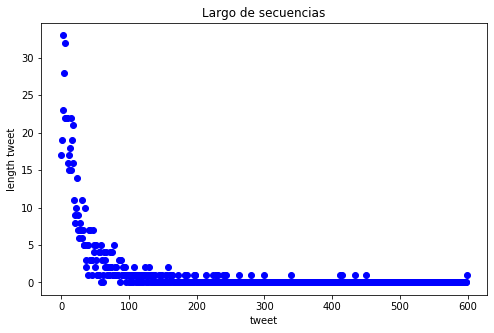

In [13]:
# Categorias: true, false, unverified, non-rumor
categories = ['true', 'false', 'unverified', 'non-rumor']
num_categories = len(categories)

#entrega un vector one-hot de la categoria, de largo 4 (por el número de categorias)
def to_category_vector(category):
    vector = np.zeros(len(categories)).astype(np.float32)
    
    for i in range(len(categories)):
        if categories[i] == category:
            vector[i] = 1.0
            break
    
    return vector

#La red neuronal necesita un tamaño fijo para la secuencia (datos de entrada)
#¿Que largo de secuencia utilizar?
counts = np.bincount(seqs_lens) ## seqs_len sólo de los 753
print(counts)
mode_seq_len = np.argmax(counts)
mean_seq_len = int(np.mean(seqs_lens))
min__seq_len = min(seqs_lens)
max__seq_len = max(seqs_lens) 
## luego se hace padding

print("seqs_lens   : ", seqs_lens)
print("min__seq_len: ", min__seq_len)
print("max__seq_len: ", max__seq_len)
print("mean_seq_len: ", mean_seq_len)
print("mode_seq_len: ", mode_seq_len )

plt.close('all')
plt.figure(figsize=(8,5))
plt.plot(counts,'bo')
plt.title("Largo de secuencias")
plt.xlabel("tweet")
plt.ylabel("length tweet")
plt.savefig('/home/kirov/plots/plt_largoSecuenciasGRU')

tree_max_num_seq = mean_seq_len

In [14]:
## padding al final, con empty
def padAWE(empty, max_num, seq):
    from itertools import repeat
    seq.extend(repeat(empty, max_num - len(seq)))
    return seq

In [15]:
## 
def generate_w2v_variant(_model, _model_vocab, _emb_size):
    
    empty_awe = np.zeros(_emb_size)
    ## Calcula AWE de cada árbol
    labeled_posts_awe = { k: (v[0], computeTreeAWE(v[1], _model, _model_vocab, _emb_size)) for k, v in labeled_posts.items() }
    ## Realiza padding a las secuencias
    padded_labeled_posts_awe = {k: (v[0], padAWE(empty_awe, tree_max_num_seq, v[1])) for k, v in labeled_posts_awe.items()}

    #Genera los datos X e Y para alimentar el modelo de red neuronal
    #Inicialmente con ceros y con la forma adecuada.
    X = np.zeros(shape=(number_of_tweets, tree_max_num_seq, _emb_size)).astype(np.float32)
    Y = np.zeros(shape=(number_of_tweets, num_categories)).astype(np.float32)

    # Asigna al vector X los datos correspondientes
    for idx, (tweet_id, tweet_data) in enumerate(list(padded_labeled_posts_awe.items())):
        for jdx, tweet_d in enumerate(tweet_data[1]):
            ### tweet_d = [uid, tweet_awe, time]
            if jdx == tree_max_num_seq:
                break            
            else:            
                X[idx, jdx, :] = tweet_d[1]

    # Asigna al vector Y los datos correspondientes            
    for idx, (tweet_id, tweet_data) in enumerate(list(padded_labeled_posts_awe.items())):
        Y[idx, :] = to_category_vector(tweet_data[0])

    print(np.shape(X))
    print(np.shape(Y))
    return X, Y

## Parte 1.3: Modelo LSTM

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, GRU


### tensorflow OMP: Error #15
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


def create_model_GRU(
            _tree_max_num_seq,
            _emb_size,
            _num_categories,
            _units = 200,
            _dropout = 0.3):
       
        model = Sequential()
        model.add(GRU(_units, input_shape=(_tree_max_num_seq, _emb_size),return_sequences=False))
        model.add(Dropout(_dropout))
        model.add(Dense(_num_categories))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model



## Parte 1.4: Funciones para graficar

In [17]:
def graphic_data(dataX, dataY, labels, title, x_label, y_label, x_min, y_min, x_max, y_max=0):
    plt.close('all') 
    plt.title(title)
    for d in dataY:
        plt.ylim(y_min,y_max)
        plt.xlim(x_min,x_max)
        plt.plot(d)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xticks(dataX)
    plt.legend(labels, loc='upper right')
    plt.savefig('/home/kirov/plots/plt_grapicDataGRU')
    plt.show()

In [18]:
#ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('/home/kirov/plots/plt_matrizGRU')

In [19]:
def plot_conf_matrix(y_true, y_pred, _title):
    y_t = y_true.argmax(1)#Yw2v50_full.argmax(1)
    y_p = y_pred.argmax(1)#Yw2v50_predict.argmax(1)
    conf_matrix = confusion_matrix(y_t, y_p)
    class_names = ['true', 'false', 'unverified', 'non-rumor']
    # Plot confusion matrix
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(conf_matrix, classes=class_names, normalize=False,
                      title=_title,cmap=plt.cm.Greens) 

## Parte 1.5: Entrenamiento y Pruebas

In [20]:
epochs = 50 #200
units_final = [128,256] #[8,16, 32, 64, 128, 256, 512, 1024]

In [21]:
#dummy_model = create_model_LSTM(10, 128)
#dummy_model = create_model_GRU(10,10,128)
#dummy_model.summary()

In [22]:
def perform_kfold_validation(X, Y, _emb_size, k = 5, _verbose = 0):
    seed = 7
    results_score = []
    results_acc   = []
    results_time  = []
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    y_pred = []

    for j, (train_idx, test_idx) in enumerate(kfold.split(X, Y.argmax(1))):
        print('\nFold ',j)
        print("\nlen train index: %s" % len(train_idx))       
        print("len test index: %s" % len(test_idx))
        X_train_cv = X[train_idx]
        Y_train_cv = Y[train_idx]
        X_test_cv  = X[test_idx]
        Y_test_cv  = Y[test_idx]
        
        #crear modelo GRU
        
        model = create_model_GRU(tree_max_num_seq,_emb_size,num_categories)
     
        start_time = time.time()
        model.fit(X_train_cv, Y_train_cv, batch_size=128, epochs=200, verbose= _verbose)     ## entrenamos
        score, acc = model.evaluate(X_test_cv, Y_test_cv, batch_size=128,verbose= _verbose) ## evaluamos /acc: accuracy
        end_time = time.time()

        print('Score: %1.4f' % score)
        print('Accuracy: %1.4f' % acc)  
        print('time: %1.4f' % (end_time - start_time))
        results_score.append(score)
        results_acc.append(acc)
        results_time.append((end_time - start_time))
    
    return results_score, results_acc, results_time

In [23]:
### https://datascience.stackexchange.com/questions/20413/clarification-on-the-keras-recurrent-unit-cell
def perform_final_validation(X, Y, X_validate, Y_validate, _emb_size, units=[8,16, 32, 64, 128, 200], _epochs=200, _verbose=1):
    h_units_score = []
    h_units_acc   = []
    history = []
    all_models = []
    for unit_size in (units): #[8,16, 32, 64, 128, 200, 512, 1024]
        print("########################")
        print("## UNIT SIZE ", unit_size)
        
        #crear modelo final GRU
        
        final_model = create_model_GRU(tree_max_num_seq,_emb_size,num_categories,_units = unit_size)

        
        final_model.summary()
        
        history.append(final_model.fit(X, Y, batch_size=128, epochs=_epochs, verbose=_verbose))
        score, acc = final_model.evaluate(X_validate, Y_validate, batch_size=128)
        h_units_score.append(score)
        h_units_acc.append(acc)
        all_models.append(final_model)
    return h_units_score, h_units_acc,history, all_models

## Parte 2: Modelo LSTM

### Modelo word2vec específico, LSTM

### Creando los vectores
Se utilizan todos los tweets etiquetados como el universo de documentos, para crear el modelo de embedding w2v

In [24]:
# build vocabulary and train model
w2v50_emb_size = 50
WINDOW = 5
W2V_EPOCHS = 50
BATCH_SIZE = 128

documents = []
for k, v in labeled_posts.items():
    for t in v[1]:
        #print(t[1]) ## sera porque algunos text estan vacios????
        # Dejar todo en lowercase
        documents.append(simple_preprocess(all_posts[t[1]]['text']))

In [25]:

w2v50_model = gensim.models.word2vec.Word2Vec(
 documents,
 size=w2v50_emb_size,
 window=WINDOW,
 min_count=2,
 workers=4,
 iter=W2V_EPOCHS
)

#Train model
w2v50_model.train(documents, total_examples=len(documents), epochs=w2v50_model.epochs)

(12009987, 16269900)

In [26]:
w2v50_model_vocab = w2v50_model.wv.vocab

In [46]:
Xw2v50_full, Yw2v50_full = generate_w2v_variant(w2v50_model, w2v50_model_vocab, w2v50_emb_size)
Xw2v50, X_1w2v50, Yw2v50, Y_1w2v50 = train_test_split(Xw2v50_full, Yw2v50_full, test_size=0.15)
perform_kfold_validation(Xw2v50, Yw2v50, w2v50_emb_size)
#perform_final_validation(Xw2v50, Yw2v50, X_1, Y_1, w2v50_emb_size) #X_1 y Y_1 Es el tamaño del set de testing
perform_final_validation(Xw2v50, Yw2v50, X_1w2v50, Y_1w2v50, w2v50_emb_size)

/home/kirov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


(753, 36, 50)
(753, 4)

Fold  0

len train index: 512
len test index: 128
Score: 4.4896
Accuracy: 0.5234
time: 180.0194

Fold  1

len train index: 512
len test index: 128
Score: 4.5946
Accuracy: 0.5469
time: 173.8425

Fold  2

len train index: 512
len test index: 128
Score: 4.4873
Accuracy: 0.5312
time: 173.1645

Fold  3

len train index: 512
len test index: 128
Score: 4.3985
Accuracy: 0.5156
time: 183.9795

Fold  4

len train index: 512
len test index: 128
Score: 4.3642
Accuracy: 0.5625
time: 195.0065
########################
## UNIT SIZE  8
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_29 (GRU)                 (None, 8)                 1416      
_________________________________________________________________
dropout_29 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_29 (Dense)             (No

640/640 [==============================] - 0s 691us/step - loss: 1.2413 - accuracy: 0.4156
Epoch 67/200
640/640 [==============================] - 0s 361us/step - loss: 1.2416 - accuracy: 0.3953
Epoch 68/200
640/640 [==============================] - 0s 314us/step - loss: 1.2431 - accuracy: 0.4219
Epoch 69/200
640/640 [==============================] - 0s 389us/step - loss: 1.2388 - accuracy: 0.4016
Epoch 70/200
640/640 [==============================] - 0s 377us/step - loss: 1.2247 - accuracy: 0.4375
Epoch 71/200
640/640 [==============================] - 0s 662us/step - loss: 1.2241 - accuracy: 0.4125
Epoch 72/200
640/640 [==============================] - 0s 530us/step - loss: 1.2161 - accuracy: 0.4250
Epoch 73/200
640/640 [==============================] - 0s 535us/step - loss: 1.1961 - accuracy: 0.4328
Epoch 74/200
640/640 [==============================] - 0s 628us/step - loss: 1.1910 - accuracy: 0.4469
Epoch 75/200
640/640 [==============================] - 0s 395us/step - loss:

640/640 [==============================] - 0s 328us/step - loss: 1.3371 - accuracy: 0.3438
Epoch 14/200
640/640 [==============================] - 0s 417us/step - loss: 1.3326 - accuracy: 0.3297
Epoch 15/200
640/640 [==============================] - 0s 296us/step - loss: 1.3272 - accuracy: 0.3578
Epoch 16/200
640/640 [==============================] - 0s 417us/step - loss: 1.3259 - accuracy: 0.3438
Epoch 17/200
640/640 [==============================] - 0s 461us/step - loss: 1.3169 - accuracy: 0.3641
Epoch 18/200
640/640 [==============================] - 0s 478us/step - loss: 1.3117 - accuracy: 0.3734
Epoch 19/200
640/640 [==============================] - 0s 325us/step - loss: 1.3073 - accuracy: 0.3656
Epoch 20/200
640/640 [==============================] - 0s 371us/step - loss: 1.3028 - accuracy: 0.3672
Epoch 21/200
640/640 [==============================] - 0s 268us/step - loss: 1.2949 - accuracy: 0.3766
Epoch 22/200
640/640 [==============================] - 0s 281us/step - loss:

/home/kirov/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125063). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


Epoch 38/200
640/640 [==============================] - 1s 1ms/step - loss: 1.1991 - accuracy: 0.4437
Epoch 39/200
640/640 [==============================] - 0s 408us/step - loss: 1.1889 - accuracy: 0.4500
Epoch 40/200
640/640 [==============================] - 0s 325us/step - loss: 1.1867 - accuracy: 0.4516
Epoch 41/200
640/640 [==============================] - 0s 337us/step - loss: 1.1629 - accuracy: 0.4672
Epoch 42/200
640/640 [==============================] - 0s 481us/step - loss: 1.1608 - accuracy: 0.4703
Epoch 43/200
640/640 [==============================] - 0s 324us/step - loss: 1.1430 - accuracy: 0.4703
Epoch 44/200
640/640 [==============================] - 0s 263us/step - loss: 1.1259 - accuracy: 0.4859
Epoch 45/200
640/640 [==============================] - 0s 338us/step - loss: 1.1132 - accuracy: 0.4969
Epoch 46/200
640/640 [==============================] - 0s 367us/step - loss: 1.0842 - accuracy: 0.5203
Epoch 47/200
640/640 [==============================] - 0s 577us/s

640/640 [==============================] - 0s 471us/step - loss: 0.3039 - accuracy: 0.9078
Epoch 195/200
640/640 [==============================] - 0s 333us/step - loss: 0.3113 - accuracy: 0.9078
Epoch 196/200
640/640 [==============================] - 0s 455us/step - loss: 0.3213 - accuracy: 0.9109
Epoch 197/200
640/640 [==============================] - 0s 445us/step - loss: 0.3059 - accuracy: 0.8953
Epoch 198/200
640/640 [==============================] - 0s 306us/step - loss: 0.3090 - accuracy: 0.9172
Epoch 199/200
640/640 [==============================] - 0s 291us/step - loss: 0.3033 - accuracy: 0.9062
Epoch 200/200
113/113 [==============================] - 1s 7ms/step
########################
## UNIT SIZE  32
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_31 (GRU)                 (None, 32)                7968      
____________________________________________________

640/640 [==============================] - 0s 475us/step - loss: 0.1839 - accuracy: 0.9547
Epoch 142/200
640/640 [==============================] - 0s 490us/step - loss: 0.1763 - accuracy: 0.9500
Epoch 143/200
640/640 [==============================] - 0s 368us/step - loss: 0.1895 - accuracy: 0.9500
Epoch 144/200
640/640 [==============================] - 0s 422us/step - loss: 0.1882 - accuracy: 0.9531
Epoch 145/200
640/640 [==============================] - 0s 393us/step - loss: 0.1771 - accuracy: 0.9547
Epoch 146/200
640/640 [==============================] - 0s 473us/step - loss: 0.2032 - accuracy: 0.9422
Epoch 147/200
640/640 [==============================] - 0s 516us/step - loss: 0.2456 - accuracy: 0.9250
Epoch 148/200
640/640 [==============================] - 0s 464us/step - loss: 0.2294 - accuracy: 0.9375
Epoch 149/200
640/640 [==============================] - 0s 484us/step - loss: 0.2479 - accuracy: 0.9250
Epoch 150/200
640/640 [==============================] - 0s 356us/ste

Epoch 10/200
640/640 [==============================] - 0s 601us/step - loss: 1.2948 - accuracy: 0.3844
Epoch 11/200
640/640 [==============================] - 0s 562us/step - loss: 1.2865 - accuracy: 0.3875
Epoch 12/200
640/640 [==============================] - 1s 782us/step - loss: 1.2709 - accuracy: 0.4094
Epoch 13/200
640/640 [==============================] - 0s 589us/step - loss: 1.2560 - accuracy: 0.4000
Epoch 14/200
640/640 [==============================] - 0s 586us/step - loss: 1.2437 - accuracy: 0.4078
Epoch 15/200
640/640 [==============================] - 0s 604us/step - loss: 1.2177 - accuracy: 0.4297
Epoch 16/200
640/640 [==============================] - 0s 690us/step - loss: 1.2066 - accuracy: 0.4328
Epoch 17/200
640/640 [==============================] - 0s 598us/step - loss: 1.1798 - accuracy: 0.4500
Epoch 18/200
640/640 [==============================] - 0s 598us/step - loss: 1.1692 - accuracy: 0.4625
Epoch 19/200
640/640 [==============================] - 0s 537us

640/640 [==============================] - 1s 793us/step - loss: 0.0159 - accuracy: 0.9984
Epoch 167/200
640/640 [==============================] - 0s 757us/step - loss: 0.0122 - accuracy: 0.9984
Epoch 168/200
640/640 [==============================] - 0s 690us/step - loss: 0.0157 - accuracy: 0.9984
Epoch 169/200
640/640 [==============================] - 0s 667us/step - loss: 0.0152 - accuracy: 0.9984
Epoch 170/200
640/640 [==============================] - 0s 680us/step - loss: 0.0123 - accuracy: 0.9984
Epoch 171/200
640/640 [==============================] - 0s 559us/step - loss: 0.0145 - accuracy: 0.9984
Epoch 172/200
640/640 [==============================] - 0s 643us/step - loss: 0.0103 - accuracy: 0.9984
Epoch 173/200
640/640 [==============================] - 0s 707us/step - loss: 0.0130 - accuracy: 0.9984
Epoch 174/200
640/640 [==============================] - 0s 698us/step - loss: 0.0151 - accuracy: 0.9984
Epoch 175/200
640/640 [==============================] - 0s 747us/ste

640/640 [==============================] - 1s 1ms/step - loss: 0.0060 - accuracy: 0.9984
Epoch 116/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0063 - accuracy: 0.9984
Epoch 117/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0083 - accuracy: 0.9984
Epoch 118/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0063 - accuracy: 0.9984
Epoch 119/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0105 - accuracy: 0.9984
Epoch 120/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0055 - accuracy: 0.9984
Epoch 121/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0089 - accuracy: 0.9984
Epoch 122/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0086 - accuracy: 0.9984
Epoch 123/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0206 - accuracy: 0.9953
Epoch 124/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0388 - a

640/640 [==============================] - 1s 2ms/step - loss: 0.0142 - accuracy: 0.9984
Epoch 65/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0128 - accuracy: 0.9984
Epoch 66/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0128 - accuracy: 0.9984
Epoch 67/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0124 - accuracy: 0.9984
Epoch 68/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0096 - accuracy: 0.9984
Epoch 69/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0092 - accuracy: 0.9984
Epoch 70/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0090 - accuracy: 0.9984
Epoch 71/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0098 - accuracy: 0.9984
Epoch 72/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0100 - accuracy: 0.9984
Epoch 73/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0107 - accuracy: 

([1.2580440044403076,
  1.844965934753418,
  2.294393301010132,
  3.1157639026641846,
  2.137141466140747,
  3.4548792839050293],
 [0.5486725568771362,
  0.5663716793060303,
  0.5929203629493713,
  0.5309734344482422,
  0.5840708017349243,
  0.6194690465927124],
  <keras.engine.sequential.Sequential at 0x7f214274bd90>])

In [47]:
print(np.sum(Yw2v50_full, axis=0)) 

[188. 180. 180. 205.]


In [48]:
#test
print(X_1w2v50.shape)
print(Y_1w2v50.shape)

(113, 36, 50)
(113, 4)


In [49]:
#train
print(Xw2v50.shape)
print(Yw2v50.shape)

(640, 36, 50)
(640, 4)


#### K-Folds w2v50, GRU

In [50]:
result_score_w2v50 = []
result_acc_w2v50   = []
resultTime_w2v50   = []

result_score_w2v50, result_acc_w2v50, resultTime_w2v50 =  perform_kfold_validation(Xw2v50, Yw2v50, w2v50_emb_size, k=5)


Fold  0

len train index: 512
len test index: 128
Score: 5.2661
Accuracy: 0.5000
time: 206.4691

Fold  1

len train index: 512
len test index: 128
Score: 4.8266
Accuracy: 0.4922
time: 183.1717

Fold  2

len train index: 512
len test index: 128
Score: 4.0444
Accuracy: 0.6016
time: 186.2682

Fold  3

len train index: 512
len test index: 128
Score: 5.4391
Accuracy: 0.5078
time: 218.1833

Fold  4

len train index: 512
len test index: 128
Score: 3.9622
Accuracy: 0.5781
time: 238.6447


#### Parte  Gráficos: K-Fold w2v50, GRU

In [51]:
data = []
data.append(result_acc_w2v50)
print(data)

[[0.5, 0.4921875, 0.6015625, 0.5078125, 0.578125]]


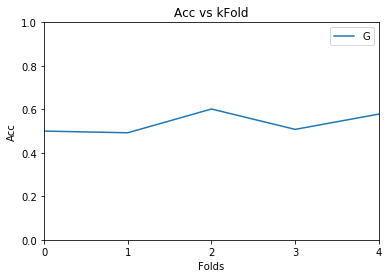

In [52]:
graphic_data([0,1,2,3,4,5],data,("GRU w2v50"),'Acc vs kFold', 'Folds', 'Acc',0,0,5,1)

#### Parte Validación: variando valor de units, w2v50, GRU

In [53]:
acc_final_w2v50 = []
score_final_w2v50 = []
history_final_w2v50 = []
models_w2v50 = []
perform_final_validation(Xw2v50, Yw2v50, X_1w2v50, Y_1w2v50, w2v50_emb_size)
score_final_w2v50,acc_final_w2v50,history_final_w2v50,models_w2v50 = perform_final_validation(Xw2v50, Yw2v50,
                                                                                X_1w2v50, Y_1w2v50, w2v50_emb_size,
                                                                                              units_final,epochs,0)

########################
## UNIT SIZE  8
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_40 (GRU)                 (None, 8)                 1416      
_________________________________________________________________
dropout_40 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_40 (Dense)             (None, 4)                 36        
_________________________________________________________________
activation_40 (Activation)   (None, 4)                 0         
Total params: 1,452
Trainable params: 1,452
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
640/640 [==============================] - 2s 3ms/step - loss: 1.4045 - accuracy: 0.2484
Epoch 2/200
640/640 [==============================] - 0s 447us/step - loss: 1.4133 - accuracy: 0.3016
Epoc

Epoch 71/200
640/640 [==============================] - 0s 363us/step - loss: 1.2437 - accuracy: 0.4094
Epoch 72/200
640/640 [==============================] - 0s 325us/step - loss: 1.2425 - accuracy: 0.4031
Epoch 73/200
640/640 [==============================] - 0s 470us/step - loss: 1.2332 - accuracy: 0.4141
Epoch 74/200
640/640 [==============================] - 0s 359us/step - loss: 1.2386 - accuracy: 0.4094
Epoch 75/200
640/640 [==============================] - 0s 433us/step - loss: 1.2274 - accuracy: 0.4313
Epoch 76/200
640/640 [==============================] - 0s 312us/step - loss: 1.2182 - accuracy: 0.4359
Epoch 77/200
640/640 [==============================] - 0s 625us/step - loss: 1.2241 - accuracy: 0.4125
Epoch 78/200
640/640 [==============================] - 1s 788us/step - loss: 1.2241 - accuracy: 0.4156
Epoch 79/200
640/640 [==============================] - 0s 330us/step - loss: 1.2145 - accuracy: 0.4281
Epoch 80/200
640/640 [==============================] - 0s 498us

640/640 [==============================] - 0s 413us/step - loss: 1.3297 - accuracy: 0.3469
Epoch 19/200
640/640 [==============================] - 0s 381us/step - loss: 1.3152 - accuracy: 0.3719
Epoch 20/200
640/640 [==============================] - 0s 356us/step - loss: 1.3126 - accuracy: 0.3688
Epoch 21/200
640/640 [==============================] - 0s 560us/step - loss: 1.3118 - accuracy: 0.3625
Epoch 22/200
640/640 [==============================] - 0s 446us/step - loss: 1.3109 - accuracy: 0.3688
Epoch 23/200
640/640 [==============================] - 0s 439us/step - loss: 1.3003 - accuracy: 0.3750
Epoch 24/200
640/640 [==============================] - 0s 537us/step - loss: 1.2912 - accuracy: 0.3781
Epoch 25/200
640/640 [==============================] - 0s 365us/step - loss: 1.2902 - accuracy: 0.3875
Epoch 26/200
640/640 [==============================] - 0s 341us/step - loss: 1.2829 - accuracy: 0.3891
Epoch 27/200
640/640 [==============================] - 0s 425us/step - loss:

640/640 [==============================] - 0s 424us/step - loss: 0.3364 - accuracy: 0.9125
Epoch 175/200
640/640 [==============================] - 0s 443us/step - loss: 0.3432 - accuracy: 0.9016
Epoch 176/200
640/640 [==============================] - 0s 345us/step - loss: 0.3334 - accuracy: 0.9047
Epoch 177/200
640/640 [==============================] - 0s 344us/step - loss: 0.3342 - accuracy: 0.9156
Epoch 178/200
640/640 [==============================] - 0s 439us/step - loss: 0.3333 - accuracy: 0.9234
Epoch 179/200
640/640 [==============================] - 0s 369us/step - loss: 0.3135 - accuracy: 0.9187
Epoch 180/200
640/640 [==============================] - 0s 522us/step - loss: 0.3279 - accuracy: 0.9156
Epoch 181/200
640/640 [==============================] - 0s 368us/step - loss: 0.3100 - accuracy: 0.9250
Epoch 182/200
640/640 [==============================] - 0s 454us/step - loss: 0.3243 - accuracy: 0.9187
Epoch 183/200
640/640 [==============================] - 0s 422us/ste

640/640 [==============================] - 0s 637us/step - loss: 0.1311 - accuracy: 0.9750
Epoch 122/200
640/640 [==============================] - 0s 526us/step - loss: 0.1271 - accuracy: 0.9766
Epoch 123/200
640/640 [==============================] - 1s 1ms/step - loss: 0.1310 - accuracy: 0.9766
Epoch 124/200
640/640 [==============================] - 0s 394us/step - loss: 0.1230 - accuracy: 0.9734
Epoch 125/200
640/640 [==============================] - 0s 332us/step - loss: 0.1193 - accuracy: 0.9781
Epoch 126/200
640/640 [==============================] - 0s 309us/step - loss: 0.1297 - accuracy: 0.9750
Epoch 127/200
640/640 [==============================] - 0s 320us/step - loss: 0.1244 - accuracy: 0.9781
Epoch 128/200
640/640 [==============================] - 1s 823us/step - loss: 0.1116 - accuracy: 0.9766
Epoch 129/200
640/640 [==============================] - 0s 396us/step - loss: 0.1100 - accuracy: 0.9781
Epoch 130/200
640/640 [==============================] - 1s 807us/step 

640/640 [==============================] - 1s 803us/step - loss: 0.0920 - accuracy: 0.9719
Epoch 69/200
640/640 [==============================] - 0s 696us/step - loss: 0.1085 - accuracy: 0.9594
Epoch 70/200
640/640 [==============================] - 0s 662us/step - loss: 0.1285 - accuracy: 0.9563
Epoch 71/200
640/640 [==============================] - 1s 801us/step - loss: 0.0961 - accuracy: 0.9797
Epoch 72/200
640/640 [==============================] - 1s 808us/step - loss: 0.0794 - accuracy: 0.9734
Epoch 73/200
640/640 [==============================] - 0s 704us/step - loss: 0.0646 - accuracy: 0.9859
Epoch 74/200
640/640 [==============================] - 0s 744us/step - loss: 0.0776 - accuracy: 0.9812
Epoch 75/200
640/640 [==============================] - 0s 563us/step - loss: 0.0727 - accuracy: 0.9797
Epoch 76/200
640/640 [==============================] - 1s 804us/step - loss: 0.0682 - accuracy: 0.9828
Epoch 77/200
640/640 [==============================] - 0s 692us/step - loss:

640/640 [==============================] - 1s 1ms/step - loss: 0.9454 - accuracy: 0.5562
Epoch 16/200
640/640 [==============================] - 1s 1ms/step - loss: 0.9046 - accuracy: 0.5859
Epoch 17/200
640/640 [==============================] - 1s 1ms/step - loss: 0.8903 - accuracy: 0.5938
Epoch 18/200
640/640 [==============================] - 1s 1ms/step - loss: 0.8418 - accuracy: 0.6109
Epoch 19/200
640/640 [==============================] - 1s 1ms/step - loss: 0.8116 - accuracy: 0.6328
Epoch 20/200
640/640 [==============================] - 1s 1ms/step - loss: 0.7749 - accuracy: 0.6484
Epoch 21/200
640/640 [==============================] - 1s 1ms/step - loss: 0.7597 - accuracy: 0.6594
Epoch 22/200
640/640 [==============================] - 1s 1ms/step - loss: 0.7492 - accuracy: 0.6578
Epoch 23/200
640/640 [==============================] - 1s 1ms/step - loss: 0.6985 - accuracy: 0.6844
Epoch 24/200
640/640 [==============================] - 1s 1ms/step - loss: 0.6654 - accuracy: 

640/640 [==============================] - 1s 1ms/step - loss: 0.0276 - accuracy: 0.9922
Epoch 96/200
640/640 [==============================] - 1s 967us/step - loss: 0.0218 - accuracy: 0.9969
Epoch 97/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0254 - accuracy: 0.9953
Epoch 98/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0246 - accuracy: 0.9953
Epoch 99/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0164 - accuracy: 0.9969
Epoch 100/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0192 - accuracy: 0.9969
Epoch 101/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0200 - accuracy: 0.9953
Epoch 102/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0148 - accuracy: 0.9969
Epoch 103/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0206 - accuracy: 0.9969
Epoch 104/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0218 - acc

640/640 [==============================] - 1s 2ms/step - loss: 0.1251 - accuracy: 0.9547
Epoch 45/200
640/640 [==============================] - 1s 2ms/step - loss: 0.1351 - accuracy: 0.9609
Epoch 46/200
640/640 [==============================] - 1s 1ms/step - loss: 0.1150 - accuracy: 0.9688
Epoch 47/200
640/640 [==============================] - 1s 2ms/step - loss: 0.1746 - accuracy: 0.9359
Epoch 48/200
640/640 [==============================] - 1s 2ms/step - loss: 0.1404 - accuracy: 0.9531
Epoch 49/200
640/640 [==============================] - 1s 2ms/step - loss: 0.1026 - accuracy: 0.9703
Epoch 50/200
640/640 [==============================] - 1s 2ms/step - loss: 0.1190 - accuracy: 0.9594
Epoch 51/200
640/640 [==============================] - 1s 2ms/step - loss: 0.1374 - accuracy: 0.9563
Epoch 52/200
640/640 [==============================] - 1s 2ms/step - loss: 0.1481 - accuracy: 0.9547
Epoch 53/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0834 - accuracy: 

640/640 [==============================] - 1s 2ms/step - loss: 1.5114e-04 - accuracy: 1.0000
Epoch 200/200
113/113 [==============================] - 1s 11ms/step
########################
## UNIT SIZE  128
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_46 (GRU)                 (None, 128)               68736     
_________________________________________________________________
dropout_46 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 4)                 516       
_________________________________________________________________
activation_46 (Activation)   (None, 4)                 0         
Total params: 69,252
Trainable params: 69,252
Non-trainable params: 0
_________________________________________________________________
113/113 [==============================] 

#### Parte  Gráficos: variando valor de units, w2v50, LSTM

In [54]:
#Preparando los datos para graficar
data_final_acc_w2v50 = []
data_final_loss_w2v50 = []


for i in np.arange(0,len(units_final)):
    data_final_acc_w2v50.append(history_final_w2v50[i].history['accuracy'])

for i in np.arange(0,len(units_final)):
    data_final_loss_w2v50.append(history_final_w2v50[i].history['loss'])
   

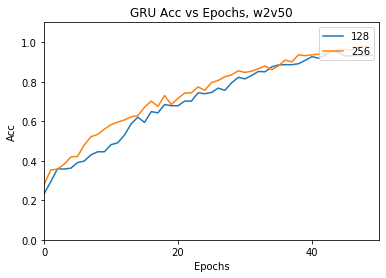

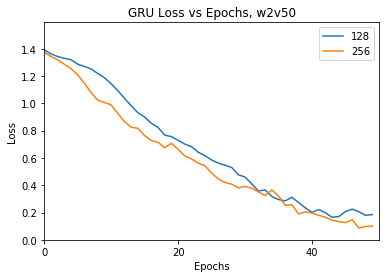

In [55]:
##Gráfico de Accuracy
graphic_data(np.arange(0,epochs,20),data_final_acc_w2v50,units_final,'GRU Acc vs Epochs, w2v50', 'Epochs', 'Acc',0,0,epochs,1+0.1)

##Gráfico de Loss 
max_loss_w2v50 = 0
for i in np.arange(0,len(data_final_loss_w2v50)):
    if(max(data_final_loss_w2v50[i]) > max_loss_w2v50):
        max_loss_w2v50 = max(data_final_loss_w2v50[i])
graphic_data(np.arange(0,epochs,20),data_final_loss_w2v50,units_final,'GRU Loss vs Epochs, w2v50', 'Epochs', 'Loss',
             0,0,epochs,max_loss_w2v50+0.2)

### Predicción: Modelo w2v50, LSTM

In [61]:
def predict_all_models(X_real, Y_real, models):
    j = 0
    all_predict = []
    counter_true =  collections.Counter(Y_real.argmax(1))
    for i in units_final:
        print("##### Predict, Units ", i,"#####")
        Y_predict_i=models[j].predict(X_real)
        counter_pred_i = collections.Counter(Y_predict_i.argmax(1))
        all_predict.append(Y_predict_i)
        print("predict: ",list(counter_pred_i.values()))
        print("Real   : ",list(counter_true.values()))
        j = j + 1
    return all_predict

In [62]:
all_predict_w2v50 = []
all_predict_w2v50 = predict_all_models(Xw2v50_full,Yw2v50_full,models_w2v50)

##### Predict, Units  128 #####
predict:  [170, 175, 169, 239]
Real   :  [188, 180, 180, 205]
##### Predict, Units  256 #####
predict:  [185, 189, 174, 205]
Real   :  [188, 180, 180, 205]


In [63]:
i = 0
for j in units_final:
    print("Units:", j, " - RMSE GRU w2v50:  ",mean_squared_error(Yw2v50_full, all_predict_w2v50[i])) #Y_true, Y_predict
    i = i + 1

Units: 128  - RMSE GRU w2v50:   0.045909442
Units: 256  - RMSE GRU w2v50:   0.031501666


#### Matriz Confusión: w2v50

In [1]:
j = 0
for i in units_final:
    plot_conf_matrix(Yw2v50_full, all_predict_w2v50[j]," Confusion word2vect, GRU, h= " + str(i))
    j = j +1

NameError: name 'units_final' is not defined